In [1]:
import xarray as xr
import xrft
import matplotlib.pyplot as plt
import numpy as np
from xgcm import Grid
from datatree import open_datatree, DataTree 

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2

In [2]:
import DG_sim_analysis_modules as sam

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load HR model
dir_HR = '/scratch/db194/mom6/base_experiments_2025/DoubleGyre/double_gyre_HR/'

ds_HR = {}
oce_geom = xr.open_dataset(dir_HR + 'ocean_geometry.nc')
oce_geom =oce_geom.rename({'lonh':'xh', 'lath':'yh', 'lonq':'xq', 'latq':'yq'})
ver_coord = xr.open_dataset(dir_HR + 'Vertical_coordinate.nc')
ver_coord = ver_coord.rename({'Layer':'zl', 'Interface':'zi'})
ds_HR['prog'] = xr.open_mfdataset(dir_HR+'prog__*.nc', decode_times=False)
#ds_HR['prog']  = ds_HR['prog'].isel(xq=slice(1,None), yq=slice(1,None))
ds_HR['prog'] = xr.merge([ds_HR['prog'], oce_geom, ver_coord])
ds_HR['oce_stats'] = xr.open_dataset(dir_HR +'ocean.stats.nc', decode_times=False)

ERROR 1: PROJ: proj_create_from_database: Open of /ext3/miniforge/share/proj failed


In [5]:
# Load HR model
dir_HR_long = '/scratch/db194/mom6/base_experiments_2025/DoubleGyre/double_gyre_HR_long/'

ds_HR_long = {}
oce_geom = xr.open_dataset(dir_HR_long + 'ocean_geometry.nc')
oce_geom =oce_geom.rename({'lonh':'xh', 'lath':'yh', 'lonq':'xq', 'latq':'yq'})
ver_coord = xr.open_dataset(dir_HR_long + 'Vertical_coordinate.nc')
ver_coord = ver_coord.rename({'Layer':'zl', 'Interface':'zi'})
ds_HR_long['prog'] = xr.open_mfdataset(dir_HR_long+'prog_*.nc', decode_times=False)
#ds_HR['prog']  = ds_HR['prog'].isel(xq=slice(1,None), yq=slice(1,None))
ds_HR_long['prog'] = xr.merge([ds_HR_long['prog'], oce_geom, ver_coord])
ds_HR_long['oce_stats'] = xr.open_dataset(dir_HR_long +'ocean.stats.nc', decode_times=False)

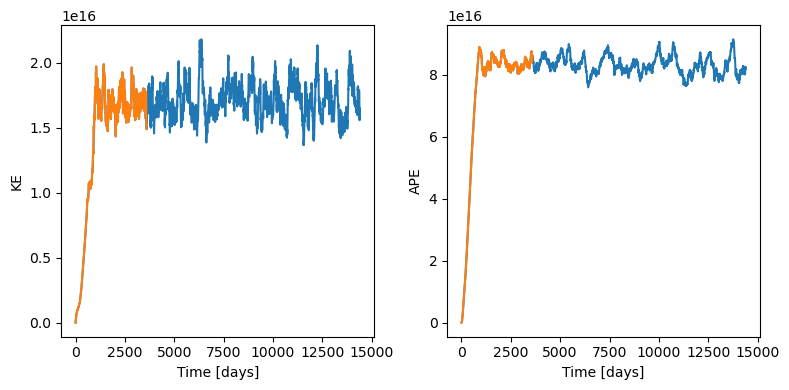

In [6]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
ds_HR_long['oce_stats'].KE.sum('Layer').plot()
ds_HR['oce_stats'].KE.sum('Layer').plot()

plt.subplot(122)
ds_HR_long['oce_stats'].APE.sum('Interface').plot()
ds_HR['oce_stats'].APE.sum('Interface').plot()

plt.tight_layout()

<xarray.DataArray 'Ah' (yh: 400, xh: 440)>
[176000 values with dtype=float64]
Coordinates:
  * yh       (yh) float64 30.02 30.07 30.12 30.18 ... 49.83 49.88 49.92 49.98
  * xh       (xh) float64 0.025 0.075 0.125 0.175 ... 21.83 21.88 21.93 21.98
Attributes:
    long_name:  Area of h cells
    units:      m2

In [9]:
def filt_coarse(ds): 
    ds_filt = sam.filter_dataset(ds).drop(['xq','yq'])
    ds_filt_coarse = sam.coarsen_dataset(ds_filt, 4)
    ds_filt['RV'] = ds_filt.dvdx - ds_filt.dudy
    ds_filt_coarse['RV'] = ds_filt_coarse.dvdx - ds_filt_coarse.dudy
    ds_filt_coarse['RV'].attrs = ds_HR['prog']['RV'].attrs
    ds_filt_coarse['Ah'] = ds['Ah'].coarsen(xh = 4, yh=4).sum()

    return ds_filt_coarse


In [10]:
ds_filt_coarse_long = filt_coarse(ds_HR_long['prog'])

coarsening


In [13]:
ds_filt_coarse = filt_coarse(ds_HR['prog'])

coarsening


In [15]:
%%time
ds_filt_coarse_long.to_netcdf(dir_HR_long+'filt_prog_100km_coarse_4.nc')

CPU times: user 2h 28min 12s, sys: 1h 23min 57s, total: 3h 52min 9s
Wall time: 1h 1min 23s


In [34]:
ds_filt_coarse.to_netcdf('/scratch/db194/mom6/base_experiments_2025/DoubleGyre/double_gyre_HR/prog_filt_100km_coarse_4.nc')

In [35]:
ds_filt_coarse

<xarray.Dataset>
Dimensions:    (Time: 720, zl: 2, yh: 100, xh: 110, zi: 3)
Coordinates:
  * yh         (yh) float64 30.1 30.3 30.5 30.7 30.9 ... 49.3 49.5 49.7 49.9
  * zl         (zl) float64 1.035e+03 1.036e+03
  * Time       (Time) float64 5.0 10.0 15.0 20.0 ... 3.59e+03 3.595e+03 3.6e+03
  * xh         (xh) float64 0.1 0.3 0.5 0.7 0.9 1.1 ... 21.1 21.3 21.5 21.7 21.9
  * zi         (zi) float64 1.034e+03 1.036e+03 1.037e+03
Data variables: (12/18)
    ubar       (Time, zl, yh, xh) float32 dask.array<chunksize=(73, 2, 100, 110), meta=np.ndarray>
    vbar       (Time, zl, yh, xh) float32 dask.array<chunksize=(73, 2, 100, 110), meta=np.ndarray>
    hbar       (Time, zl, yh, xh) float32 dask.array<chunksize=(73, 2, 100, 110), meta=np.ndarray>
    ebar       (Time, zi, yh, xh) float32 dask.array<chunksize=(73, 3, 100, 110), meta=np.ndarray>
    uphp       (Time, zl, yh, xh) float32 dask.array<chunksize=(73, 2, 100, 110), meta=np.ndarray>
    vphp       (Time, zl, yh, xh) float32 dask.array<chunksize=(73, 2, 100, 110), meta=np.ndarray>
    ...         ...
    dedx       (Time, zi, yh, xh) float64 dask.array<chunksize=(73, 3, 100, 110), meta=np.ndarray>
    dedy       (Time, zi, yh, xh) float64 dask.array<chunksize=(73, 3, 100, 110), meta=np.ndarray>
    dhdx       (Time, zl, yh, xh) float64 dask.array<chunksize=(73, 2, 100, 110), meta=np.ndarray>
    dhdy       (Time, zl, yh, xh) float64 dask.array<chunksize=(73, 2, 100, 110), meta=np.ndarray>
    RV         (Time, zl, yh, xh) float64 dask.array<chunksize=(73, 2, 100, 110), meta=np.ndarray>
    Ah         (yh, xh) float64 4.288e+08 4.288e+08 ... 3.193e+08 3.193e+08